### Prerequisites for Data Preprocessing

Before running this notebook, ensure the following steps are completed:

1. **Python Environment**:  
   - Ensure Python 3.8 or higher is installed.

2. **Install Required Dependencies**:  
   - Run the following command to install all necessary dependencies:  
     ```bash
     pip install -r requirements.txt
     ```

3. **Conduct Exploratory Data Analysis (optional):**
    - Conduct the [EDA](exploratory_data_analysis.ipynb) to better understand the data.
    - View the raw datasets ([1](../data/tweets.csv)) ([2](../data/stock_yfinance_data.csv)) and identify issues to fix
    
The following code block imports all necessary Python libraries for data preprocessing.

In [1]:
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

### **Loading and Preprocessing Tweets**  
In this step, we:  

1. **Load the Raw Tweet Data**  
   - The raw Tweets are loaded from the file `../data/tweets.csv`. Ensure this file is available in the specified directory.  

2. **Preprocess the Text Data**  
   - A custom function, `preprocess_text`, is defined to clean and normalize the text. The following transformations are applied:  
     - Convert all text to lowercase.  
     - Remove URLs (e.g., links starting with `http` or `www`).  
     - Remove mentions (e.g., `@username`) and hashtags (e.g., `#topic`).  
     - Remove non-alphanumeric characters (e.g., punctuation).  
     - Convert emojis to their textual descriptions using the `emoji` library (e.g., 😊 → `:smiling_face:`).  
     - Remove extra whitespace.  

3. **Apply Preprocessing**  
   - The `preprocess_text` function is applied to the `Tweet` column in the dataset.  

4. **Save the Preprocessed Data**  
   - Finally, the cleaned data is saved to a new file named `../data/preprocessed_tweets.csv`. This file will be used in subsequent steps for sentiment analysis.  


In [2]:
all_tweets = pd.read_csv(r'../data/tweets.csv')
all_tweets['Date'] = pd.to_datetime(all_tweets['Date'])

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'@\w+|#\w+', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = emoji.demojize(text)  
    text = " ".join(text.split())  
    return text

all_tweets['Tweet'] = all_tweets['Tweet'].apply(preprocess_text)
all_tweets.to_csv(r'../data/preprocessed_tweets.csv', index=False)

### **Adding Technical Indicators to Historical Price Data**  
In this step, we enrich the historical stock price data with technical indicators that are commonly used in financial analysis. These indicators will later serve as features for our forecasting models.  

1. **Load the Historical Price Data**  
   - The historical stock price data is loaded from the file `../data/stock_yfinance_data.csv`. Ensure this file is available and formatted correctly with columns like `Adj Close`, `Close`, and `Open`.  
   - From [the EDA](exploratory_data_analysis.ipynb), it was seen that the `Date` column had a data type of an object, however this stops us from accessing time chronologically, which is why the `Date` column's data type was changed/ 

2. **Generate Technical Indicators**  
   - A function, `get_technical_indicators`, is defined to compute the following indicators:  
     - **Moving Averages (MA7, MA20):** Rolling averages over 7 and 20 days, smoothing out short-term fluctuations.  
     - **MACD (Moving Average Convergence Divergence):** The difference between two Exponential Moving Averages (26-day and 12-day), indicating trend strength.  
     - **Bollinger Bands (Upper Band, Lower Band):** Bands around the 20-day moving average, calculated as `MA20 ± (2 * 20-day standard deviation)`, useful for volatility analysis.  
     - **Exponential Moving Average (EMA):** A weighted moving average that reacts more significantly to recent price changes.  
     - **Log Momentum:** Logarithmic momentum of the stock prices, capturing recent trends.  

3. **Save the Enhanced Data**  
   - The enhanced dataset, now containing the original data along with the computed technical indicators, is saved to `../data/preprocessed_stock_data.csv`.  

4. **Preview the Data**  
   - The first few rows of the enhanced dataset are displayed to verify the addition of the indicators.  

**Note:**  
Ensure that the file path `../data/stock_yfinance_data.csv` is accurate and that the `../data/` directory has the necessary permissions f

In [3]:
historical_data = pd.read_csv('../data/stock_yfinance_data.csv')
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

def get_technical_indicators(data):
    data['MA7'] = data.loc[:,"Adj Close"].rolling(window=7).mean()
    data['MA20'] = data.loc[:,"Adj Close"].rolling(window=20).mean()
    data['MACD'] = data.loc[:,"Close"].ewm(span=26).mean() - data.loc[:,"Open"].ewm(span=12,adjust=False).mean()
    data['20SD'] = data.loc[:, "Adj Close"].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)
    data['EMA'] = data.loc[:,"Adj Close"].ewm(com=0.5).mean()
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)
    return data

historical_data = get_technical_indicators(historical_data)
historical_data.to_csv(r'../data/preprocessed_stock_data.csv', index=False)

### **Visualizing Technical Indicators**
This section provides a function to visualize the computed technical indicators for a single stock. While the technical indicators are calculated for all stocks in the dataset, this function allows you to focus on one stock at a time by specifying its stock name and company name.

---
#### **Inputs**
Change these variables in the code accordingly:
1. **`stock_name`**: The stock ticker symbol (e.g., `'TSLA'` for Tesla).  
2. **`company_name`**: The full company name corresponding to the stock (e.g., `'Tesla'`).  
---

#### **Steps**
1. **Filter Data for Selected Stock**  
   - The dataset is filtered to include only rows where the `Stock Name` matches the specified `stock_name`.  
   - This ensures the visualization is tailored to the selected stock.

2. **Plot Technical Indicators**  
   - The function `plot_technical_indicators()` visualizes the following for the selected stock:
     - **Closing Price**: The actual stock price.
     - **Moving Averages (MA7, MA20)**: Trend-following indicators for short-term and medium-term price trends.
     - **Bollinger Bands (Upper and Lower)**: Indicators of market volatility.
     - **Exponential Moving Average (EMA)**: Highlights recent market trends.  
   - The x-axis is formatted to display the year, and labels and a legend are added for clarity.  

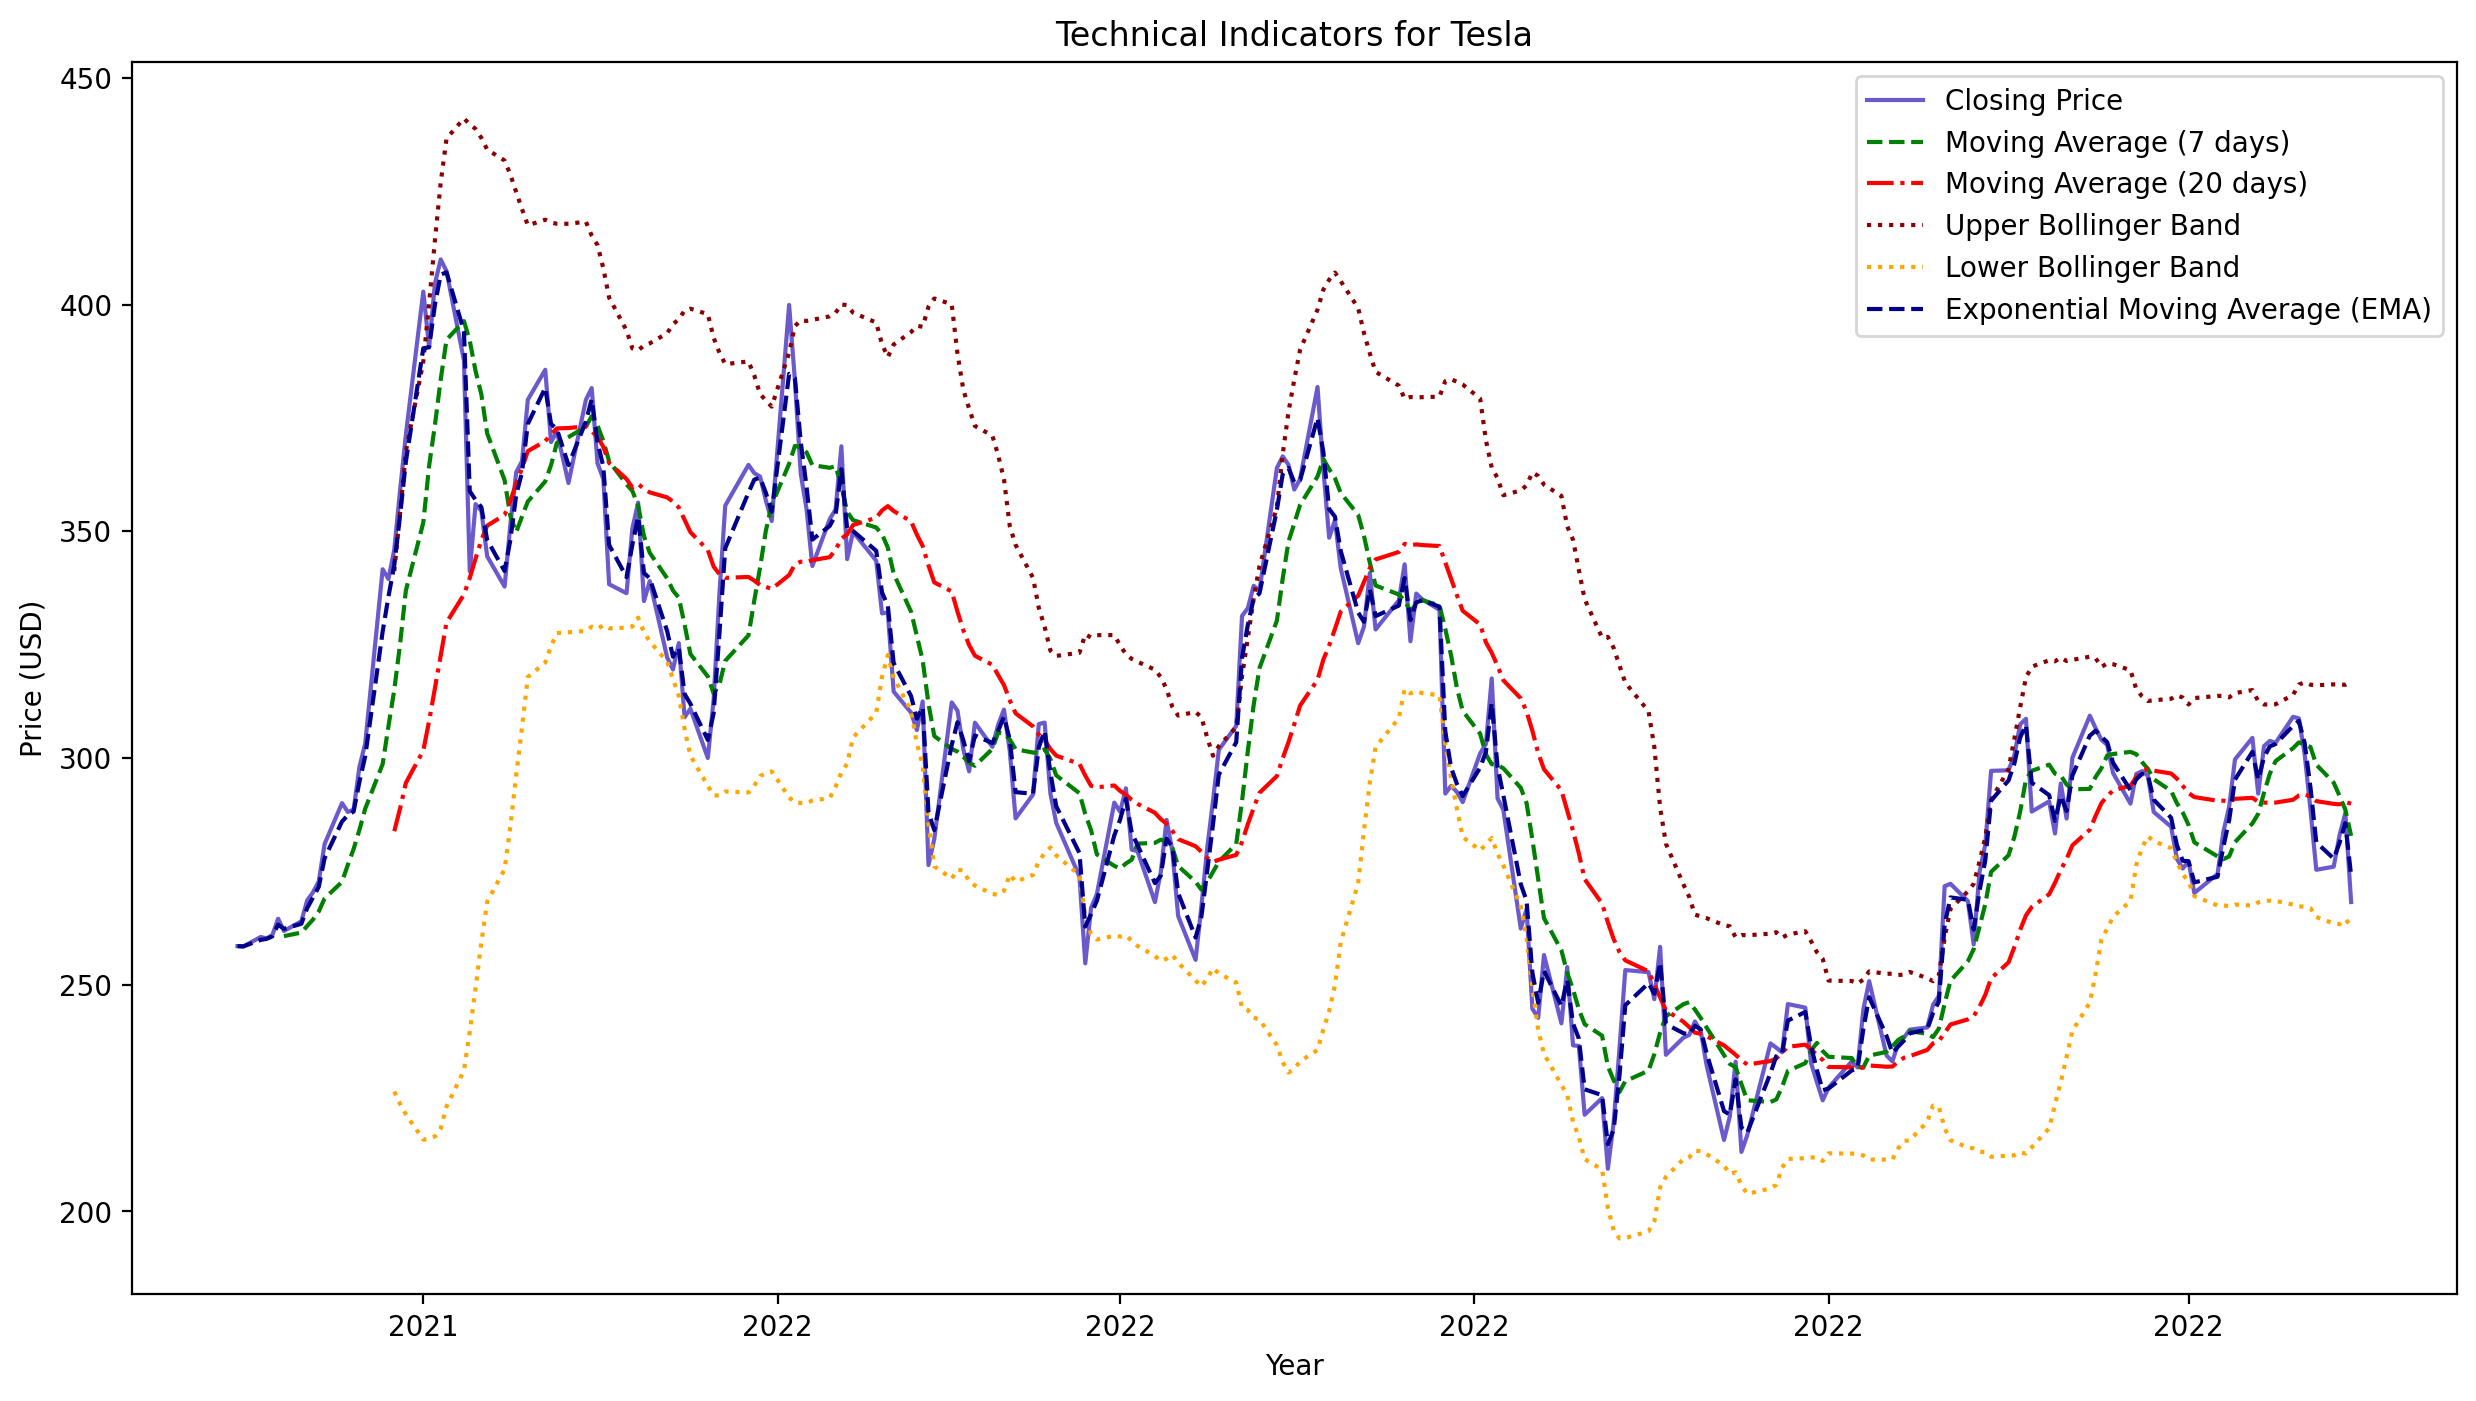

In [4]:
def plot_technical_indicators(dataset, company_name):
    fig, ax = plt.subplots(figsize=(15, 8), dpi=200)    #
    ax.plot(dataset['Date'], dataset['Adj Close'], label='Closing Price', color='#6A5ACD')
    
    # Plot the technical indicators
    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['upper_band'], label='Upper Bollinger Band', color='darkred', linestyle=':')
    ax.plot(dataset['Date'], dataset['lower_band'], label='Lower Bollinger Band', color='orange', linestyle=':')
    ax.plot(dataset['Date'], dataset['EMA'], label='Exponential Moving Average (EMA)', color='darkblue', linestyle='--')

    # Add the graph's title and labels
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title(f'Technical Indicators for {company_name}')
    plt.ylabel('Price (USD)')
    plt.xlabel("Year")
    plt.legend()
    
    # Show the visualization
    plt.show()


stock_name = 'TSLA'
company_name = 'Tesla'
df_stock = historical_data[historical_data['Stock Name'] == stock_name]
df_stock.head()
plot_technical_indicators(df_stock, company_name)